In [6]:
!pip install tensorflow


[STEP] Loading Ames Housing dataset...
[TRY] Fetching from OpenML (needs internet)...
[OK] OpenML loaded successfully. Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


[CLEAN] Dropped 0 duplicates. New shape: (1460, 81)
[CLEAN] Dropped 0 missing targets. New shape: (1460, 81)


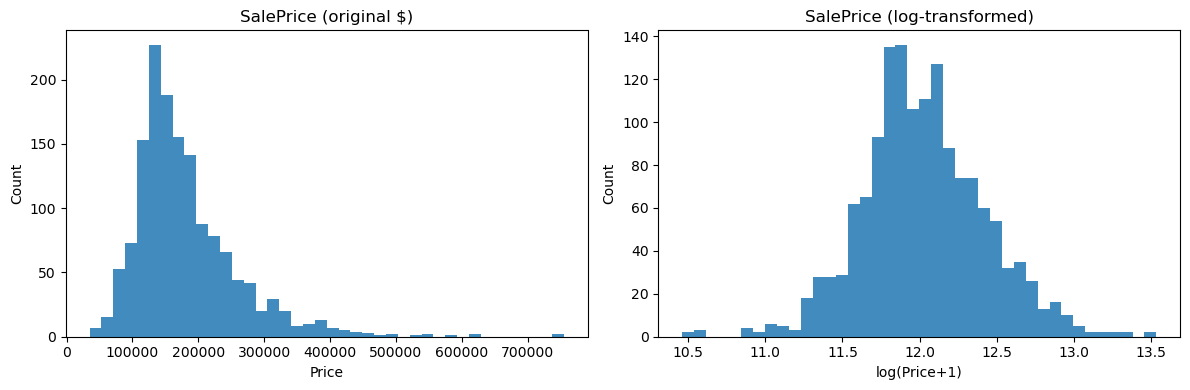

[SPLIT] Train: (1168, 80), Test: (292, 80)
[INFO] #Numeric: 37 | #Categorical: 43

[TRAIN] Fitting baseline RandomForest ...

=== RandomForest (Baseline, ML) ===
MAE : 17,267.22
RMSE: 31,117.30
R²  : 0.7977

[TUNE] Running GridSearchCV ... (this takes some time)
[BEST PARAMS] → {'regressor__rf__max_depth': None, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__n_estimators': 400}

=== RandomForest (Tuned, ML) ===
MAE : 17,073.79
RMSE: 30,004.50
R²  : 0.8120

[DL] Preparing Neural Network ...
[DL] Training Neural Network (takes some time) ...
Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 46.4772 - mae: 5.6842 - val_loss: 4.9380 - val_mae: 2.0884
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0230 - mae: 0.7890 - val_loss: 0.4264 - val_mae: 0.5292
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2081 - mae: 0.3489 - val_loss: 0.2113 - val_mae: 0.3481
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1211 - mae: 0.2659 - val_loss: 0.

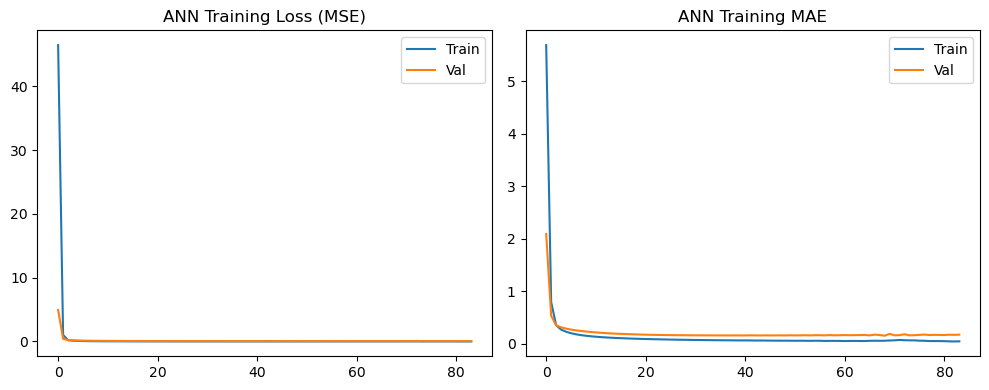

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

=== Neural Network (DL) ===
MAE : 23,737.90
RMSE: 55,962.60
R²  : 0.3458


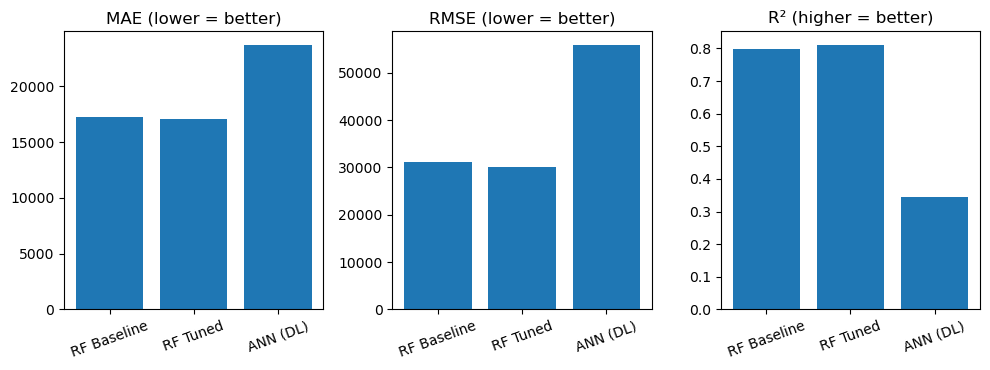


✅ FINAL COMPARISON:
RandomForest (Baseline): MAE 17,267, RMSE 31,117, R² 0.798
RandomForest (Tuned):    MAE 17,074, RMSE 30,005, R² 0.812
Neural Network (DL):     MAE 23,738, RMSE 55,963, R² 0.346


In [12]:
# ============================================================
# House Price Regression (Ames Dataset)
# Machine Learning (Random Forest) + Deep Learning (Neural Network)
# ============================================================

# ------------------------------------------------------------
# 0. IMPORTS & SETUP
# ------------------------------------------------------------

# `warnings` is used to suppress extra messages (to make output cleaner)
import warnings
warnings.filterwarnings("ignore")

# Standard Python libraries
import os
import numpy as np
import pandas as pd
from math import sqrt  # used for RMSE calculation (root mean square error)

# Visualization library for plotting graphs
import matplotlib.pyplot as plt
from IPython.display import display  # better table display in Jupyter

# Machine learning (Scikit-learn)
from urllib.error import URLError
from sklearn.datasets import fetch_openml  # to load dataset from OpenML
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------------------------------------
# 1. LOAD DATASET (Either Online from OpenML or Local CSV)
# ------------------------------------------------------------
print("[STEP] Loading Ames Housing dataset...")

# Define the name of the target column (the one that want to predict)
TARGET = "SalePrice"

# Local CSV path 
local_csv = r"C:\Users\Admin\OneDrive\Data_ML\house_prices_train.csv"

# Try loading the data from OpenML first
try:
    print("[TRY] Fetching from OpenML (needs internet)...")
    ames = fetch_openml(name="house_prices", version=1, as_frame=True)
    df = ames.frame.copy()
    print("[OK] OpenML loaded successfully. Shape:", df.shape)

except Exception as e:
    # If no internet, fall back to your local CSV
    print("[WARN] OpenML failed:", repr(e))
    print(f"[TRY] Loading local CSV: {local_csv}")
    if not os.path.exists(local_csv):
        raise FileNotFoundError(
            f"Local CSV not found at:\n  {local_csv}\nPlease check your path!"
        )
    df = pd.read_csv(local_csv)
    print("[OK] Local CSV loaded successfully. Shape:", df.shape)

# Check if the target column exists
if TARGET not in df.columns:
    raise ValueError("Target column 'SalePrice' not found in dataset!")

# Display first 3 rows (to confirm columns)
display(df.head(3))

# ------------------------------------------------------------
# 2️. DATA CLEANING
# ------------------------------------------------------------

# Remove exact duplicate rows (sometimes data contains repeated entries)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"[CLEAN] Dropped {before - after} duplicates. New shape: {df.shape}")

# Drop rows where the target (SalePrice) is missing
before = df.shape[0]
df = df[~df[TARGET].isna()].copy()
after = df.shape[0]
print(f"[CLEAN] Dropped {before - after} missing targets. New shape: {df.shape}")

# ------------------------------------------------------------
# 3️. VISUALIZE TARGET DISTRIBUTION
# ------------------------------------------------------------
# Helps to understand how the prices are distributed (skewed or not)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df[TARGET].dropna(), bins=40, alpha=0.85)
plt.title("SalePrice (original $)")
plt.xlabel("Price"); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(np.log1p(df[TARGET].dropna()), bins=40, alpha=0.85)
plt.title("SalePrice (log-transformed)")
plt.xlabel("log(Price+1)"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4️. HANDLE OUTLIERS USING IQR (Interquartile Range)
# ------------------------------------------------------------
# IQR = Q3 - Q1 (the range between 25th and 75th percentile)
# This helps cap extreme values that could distort the model.

numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

# Columns that commonly have extreme values
numeric_feature_candidates = [
    c for c in ["LotArea", "GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea"]
    if c in numeric_cols_all
]

def iqr_cap(series, k=3.0):
    """
    Caps extreme values to within [Q1 - k*IQR, Q3 + k*IQR].
    k=3.0 → only very extreme outliers are affected.
    """
    q1, q3 = np.nanpercentile(series.astype(float), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return series.clip(lower, upper)

for col in numeric_feature_candidates:
    df[col] = iqr_cap(df[col], k=3.0)

# ------------------------------------------------------------
# 5️. TARGET TRANSFORMATION (log-price) + STRATIFIED SPLIT
# ------------------------------------------------------------
# “Skewed target” = many cheap houses, few very expensive ones.
# To fix this imbalance:
# - Apply log() to SalePrice (makes it smoother)
# - Use sample weights (rare price ranges = higher weight)
# - Use stratified split so both train/test have similar price distribution
# - logarithm of the house price

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)

n_bins = 8  # divide prices into 8 bins (quantiles)
df["_price_bin"] = pd.qcut(df[TARGET], q=n_bins, duplicates="drop")
bin_counts = df["_price_bin"].value_counts().to_dict()
df["_sample_weight"] = df["_price_bin"].map(lambda b: 1.0 / bin_counts[b])

# Separate features (X) and target (y)
X = df.drop(columns=[TARGET, "_price_bin", "_sample_weight"])
y = df[TARGET].copy()
strata = df["_price_bin"].astype(str)

# Split the data 80/20 (train/test) — stratify keeps price distribution balanced
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, df["_sample_weight"], test_size=0.2, random_state=42, stratify=strata
)
print(f"[SPLIT] Train: {X_train.shape}, Test: {X_test.shape}")

# ------------------------------------------------------------
# 6️. PREPROCESSING (Numeric + Categorical)
# ------------------------------------------------------------
# - Numeric data: fill missing values with median + scale (normalize)
# - Categorical data: fill missing with most frequent + one-hot encode (convert to numbers)

# Numeric & categorical column separation
numeric_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_cols = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]
print(f"[INFO] #Numeric: {len(numeric_cols)} | #Categorical: {len(categorical_cols)}")

# Numeric preprocessing: fill missing with median + scale
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Categorical preprocessing: fill missing with most frequent + one-hot encode
try:
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ])
except TypeError:
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True)),
    ])

# Combine both numeric and categorical transformations
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop",
)

# ------------------------------------------------------------
# 7️. MACHINE LEARNING MODEL — RANDOM FOREST
# ------------------------------------------------------------
# RandomForest = group of many decision trees (an ensemble method).
# Each tree predicts independently, and the final result is their average.

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# TransformedTargetRegressor ensures the model learns on log(target)
rf_model = TransformedTargetRegressor(
    regressor=Pipeline([("pre", preprocess), ("rf", rf)]),
    transformer=log_transformer
)

print("\n[TRAIN] Fitting baseline RandomForest ...")
rf_model.fit(X_train, y_train, rf__sample_weight=w_train)

# Function for evaluation metrics
def evaluate(name, y_true, y_pred):
    """
    MAE  = Mean Absolute Error (average $ difference)
    RMSE = Root Mean Squared Error (penalizes large errors)
    R²   = Coefficient of Determination (1.0 = perfect, 0.0= useless)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Evaluate baseline RandomForest (with default settings)
rf_preds = rf_model.predict(X_test)
rf_base = evaluate("RandomForest (Baseline, ML)", y_test, rf_preds)

# ------------------------------------------------------------
# 8️. HYPERPARAMETER TUNING (GridSearchCV for tuned)
# ------------------------------------------------------------
# GridSearchCV = tries different combinations of parameters
# using KFold cross-validation (splits data into parts to test accuracy)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid (values to try)
rf_grid = {
    "regressor__rf__n_estimators": [200, 400],
    "regressor__rf__max_depth": [None, 12, 20],
    "regressor__rf__min_samples_leaf": [1, 2, 5],
}

rf_gs = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

print("\n[TUNE] Running GridSearchCV ... (this takes some time)") # find better parameters(control how model learns)
rf_gs.fit(X_train, y_train, rf__sample_weight=w_train)
print("[BEST PARAMS] →", rf_gs.best_params_)

rf_tuned = rf_gs.best_estimator_
rf_tuned_preds = rf_tuned.predict(X_test)
rf_tuned_results = evaluate("RandomForest (Tuned, ML)", y_test, rf_tuned_preds)

# ------------------------------------------------------------
# 9️. DEEP LEARNING MODEL — ARTIFICIAL NEURAL NETWORK (ANN)
# ------------------------------------------------------------
# Build a simple fully connected neural network using Keras (TensorFlow backend).
# ANN can learn complex nonlinear relationships.

print("\n[DL] Preparing Neural Network ...")

# Preprocess data for Neural Network (convert to numeric arrays)
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre = preprocess.transform(X_test)

# Convert sparse(0) to dense(everything) if needed
if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
if hasattr(X_test_pre, "toarray"):
    X_test_pre = X_test_pre.toarray()

# Convert targets to log-scale (like RandomForest)
y_train_log = np.log1p(y_train.values)
y_test_log = np.log1p(y_test.values)

# Import TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.utils.set_random_seed(42)  # reproducibility

# Define the model architecture
model = keras.Sequential([
    layers.Input(shape=(X_train_pre.shape[1],)),  # number of features
    layers.Dense(128, activation='relu'),         # hidden layer 1
    layers.Dense(64, activation='relu'),          # hidden layer 2
    layers.Dense(1)                               # output layer (regression)
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping = stop when validation performance stops improving
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("[DL] Training Neural Network (takes some time) ...")
history = model.fit(
    X_train_pre, y_train_log,
    validation_split=0.1,  # 10% of training for validation
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# ------------------------------------------------------------
# 10. PLOT TRAINING CURVES
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("ANN Training Loss (MSE)"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Val')
plt.title("ANN Training MAE"); plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 11. EVALUATE NEURAL NETWORK
# ------------------------------------------------------------
# Predict log-prices then convert back to normal $ scale
y_pred_log_dl = model.predict(X_test_pre).flatten()
y_pred_dl = np.expm1(y_pred_log_dl)

dl_results = evaluate("Neural Network (DL)", y_test, y_pred_dl)

# ------------------------------------------------------------
# 12. COMPARE ML vs DL
# ------------------------------------------------------------
labels = ["RF Baseline", "RF Tuned", "ANN (DL)"]
mae_vals = [rf_base["MAE"], rf_tuned_results["MAE"], dl_results["MAE"]]
rmse_vals = [rf_base["RMSE"], rf_tuned_results["RMSE"], dl_results["RMSE"]]
r2_vals = [rf_base["R2"], rf_tuned_results["R2"], dl_results["R2"]]

plt.figure(figsize=(10,3.8))
plt.subplot(1,3,1)
plt.bar(labels, mae_vals)
plt.title("MAE (lower = better)"); plt.xticks(rotation=20)

plt.subplot(1,3,2)
plt.bar(labels, rmse_vals)
plt.title("RMSE (lower = better)"); plt.xticks(rotation=20)

plt.subplot(1,3,3)
plt.bar(labels, r2_vals)
plt.title("R² (higher = better)"); plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print("\n FINAL COMPARISON:")
print(f"RandomForest (Baseline): MAE {rf_base['MAE']:,.0f}, RMSE {rf_base['RMSE']:,.0f}, R² {rf_base['R2']:.3f}")
print(f"RandomForest (Tuned):    MAE {rf_tuned_results['MAE']:,.0f}, RMSE {rf_tuned_results['RMSE']:,.0f}, R² {rf_tuned_results['R2']:.3f}")
print(f"Neural Network (DL):     MAE {dl_results['MAE']:,.0f}, RMSE {dl_results['RMSE']:,.0f}, R² {dl_results['R2']:.3f}")
